In [1]:
import numpy as np
import pandas as pd
import nmp_util
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
mjd = pd.read_csv('GRCAT07001ACC.sec', delimiter = r'\s+', names = ['mjd'], skiprows = 8, nrows=1)
data_cols = ['R_lin','S_lin','W_lin','R_ang','S_ang','W_ang']
data = pd.read_csv('GRCAT07001ACC.sec', delimiter = r'\s+', names = ['dmjd'] + data_cols, skiprows = 9)
date = nmp_util.mjd_to_datetime(data['dmjd'] + mjd['mjd'][0])
data['date'] = date

In [3]:
display(data)

,dmjd,R_lin,S_lin,W_lin,R_ang,S_ang,W_ang,date
0,0.000000,0.000011,0.000048,-0.000003,0.301015,-0.329681,-0.039378,2007-01-01 00:00:00.000000000
1,0.000012,0.000011,0.000048,-0.000003,0.301055,-0.329769,-0.039365,2007-01-01 00:00:01.000000512
2,0.000023,0.000011,0.000048,-0.000003,0.301034,-0.329567,-0.039391,2007-01-01 00:00:02.000000000
3,0.000035,0.000011,0.000048,-0.000003,0.301044,-0.329789,-0.039386,2007-01-01 00:00:03.000000512
4,0.000046,0.000011,0.000048,-0.000003,0.301064,-0.329831,-0.039393,2007-01-01 00:00:04.000000000
...,...,...,...,...,...,...,...,...
86394,0.999931,0.000011,0.000007,-0.000012,0.301017,-0.329934,-0.039382,2007-01-01 23:59:54.000000000
86395,0.999942,0.000011,0.000007,-0.000012,0.300989,-0.329819,-0.039438,2007-01-01 23:59:55.000000512
86396,0.999954,0.000011,0.000007,-0.000012,0.300978,-0.329556,-0.039427,2007-01-01 23:59:56.000000000
86397,0.999965,0.000011,0.000007,-0.000012,0.300958,-0.329908,-0.039864,2007-01-01 23:59:56.999999488


In [4]:
# sample every 10th entry
data_sample = data.loc[::10]
display(data_sample)

,dmjd,R_lin,S_lin,W_lin,R_ang,S_ang,W_ang,date
0,0.000000,0.000011,0.000048,-0.000003,0.301015,-0.329681,-0.039378,2007-01-01 00:00:00
10,0.000116,0.000011,0.000048,-0.000003,0.301072,-0.329640,-0.039245,2007-01-01 00:00:10
20,0.000231,0.000012,0.000048,-0.000002,0.301110,-0.329943,-0.039259,2007-01-01 00:00:20
30,0.000347,0.000012,0.000049,-0.000002,0.301066,-0.329852,-0.039352,2007-01-01 00:00:30
40,0.000463,0.000013,0.000049,-0.000003,0.301104,-0.329926,-0.039395,2007-01-01 00:00:40
...,...,...,...,...,...,...,...,...
86350,0.999421,0.000011,0.000006,-0.000013,0.300987,-0.329930,-0.039264,2007-01-01 23:59:10
86360,0.999537,0.000011,0.000006,-0.000013,0.300949,-0.329516,-0.039304,2007-01-01 23:59:20
86370,0.999653,0.000011,0.000006,-0.000012,0.300992,-0.330410,-0.039557,2007-01-01 23:59:30
86380,0.999769,0.000012,0.000007,-0.000012,0.300986,-0.329946,-0.039606,2007-01-01 23:59:40


In [5]:
def analize_data(date : np.ndarray, original : np.ndarray, window : int, edge):
    # Ctop the date and data depending on how the edge is handled
    cropped = original[window// 2:-window // 2+1] if edge == 'none' else original
    cropped_date = date[window // 2:-window // 2+1] if edge == 'none' else date

    def plot_amplitude_spectrum(data,label, d = 10, max_period = 30, exponent = 1):
        freq, amplitude = nmp_util.amplitude_spectrum_via_numpy(data, d = d)
        # only use positive frequencies with a period smaller than max_period
        mask = (freq < 1/max_period) & (freq > 0)
        # convert to units of minutes
        plt.plot(1/(60*freq[mask]), amplitude[mask]**exponent, label=label)

    for i in range(3):
        # Low-pass filter

        l = nmp_util.savitzki_golay_filter(original, deg = i, window = window, edge=edge)
        h = cropped - l

        # plot the entire data (filtered and original)
        plt.figure(figsize=(10, 5))
        plt.scatter(date, original, label=f'Original', s=1)
        plt.scatter(cropped_date, h, label=f'High-pass q={i}', s=1)
        plt.scatter(cropped_date, l, label=f'Low-pass q={i}', s=1)
        plt.xlabel('Date')
        plt.ylabel('Acceleration [mm/s$^2$]')
        plt.legend()
        plt.show()
        
        # create zoom for one hour (360 entries)
        s, e = 0, 360
        plt.figure(figsize=(10, 5))
        plt.scatter(date[s:e], original[s:e], label=f'Original', s=1)
        plt.scatter(cropped_date[s:e], h[s:e], label=f'High-pass q={i}', s=1)
        plt.scatter(cropped_date[s:e], l[s:e], label=f'Low-pass q={i}', s=1)
        plt.xlabel('Date')
        plt.ylabel('Acceleration [mm/s$^2$]')
        plt.legend()
        plt.show()
        
        # plot the amplitude spectrum
        
        plt.figure(figsize=(10, 5))
        plot_amplitude_spectrum(original, 'Original')
        plot_amplitude_spectrum(l, f'Low-pass q={i}')
        plot_amplitude_spectrum(h, f'High-pass q={i}')
        plt.xlabel('Period [min]')
        plt.ylabel('Amplitude [mm/s$^2$]')
        plt.xscale('log') 
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plot_amplitude_spectrum(original, 'Original',  exponent = 2)
        plot_amplitude_spectrum(l, f'Low-pass q={i}',  exponent = 2)
        plot_amplitude_spectrum(h, f'High-pass q={i}', exponent = 2)
        plt.xlabel('Period [min]')
        plt.ylabel('Power [mm^2/s$^4$]')
        plt.xscale('log') 
        plt.legend()
        plt.show()

# Note:
the filters for q=0 and q=1 are equivalent, but only because i evaluate at x=0, and the data points are equidistant!

In [6]:
#analize_data(data_sample['date'], data_sample['S_lin'], window = 61, edge = 'none')

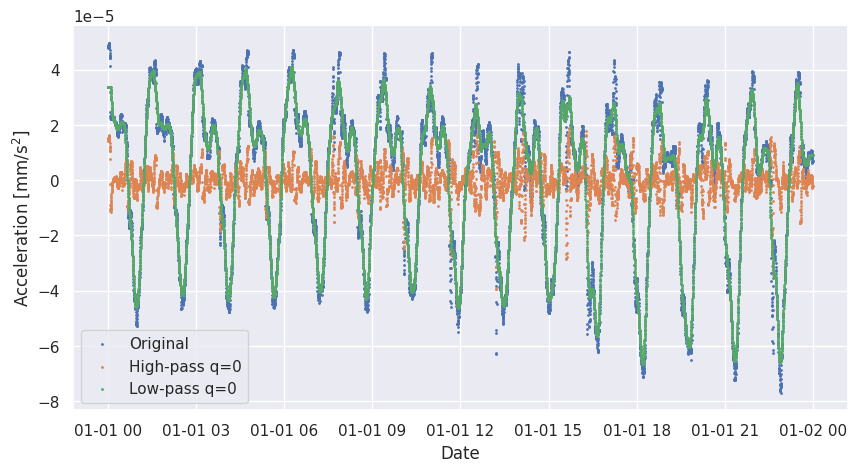

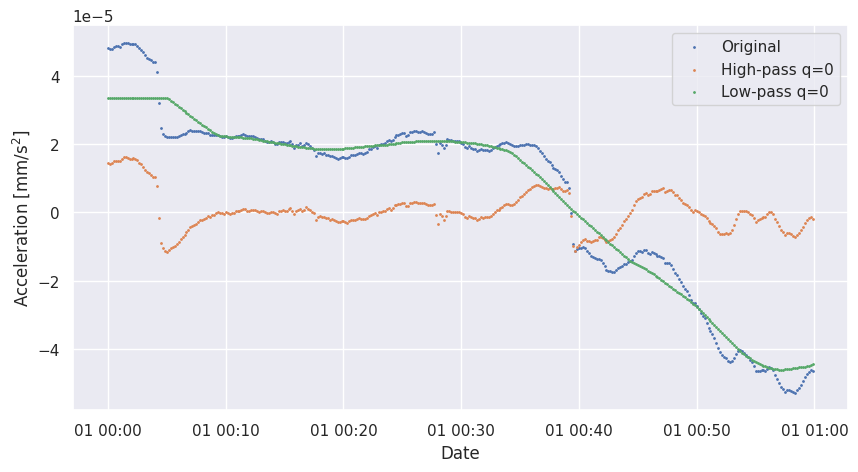

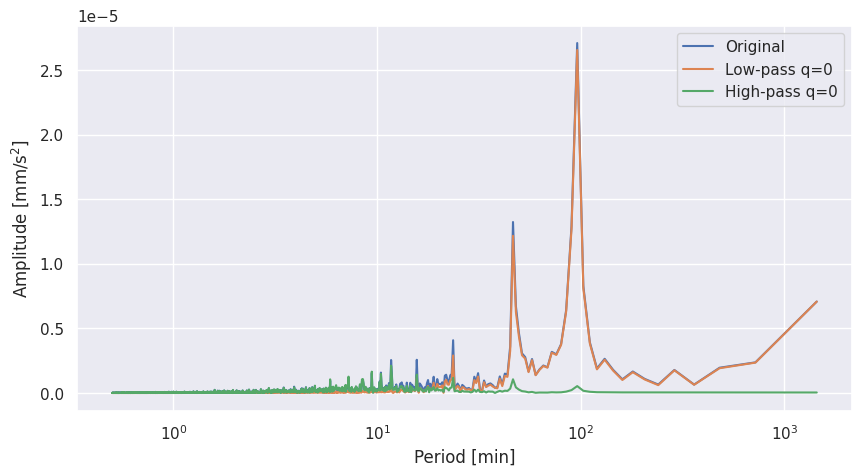

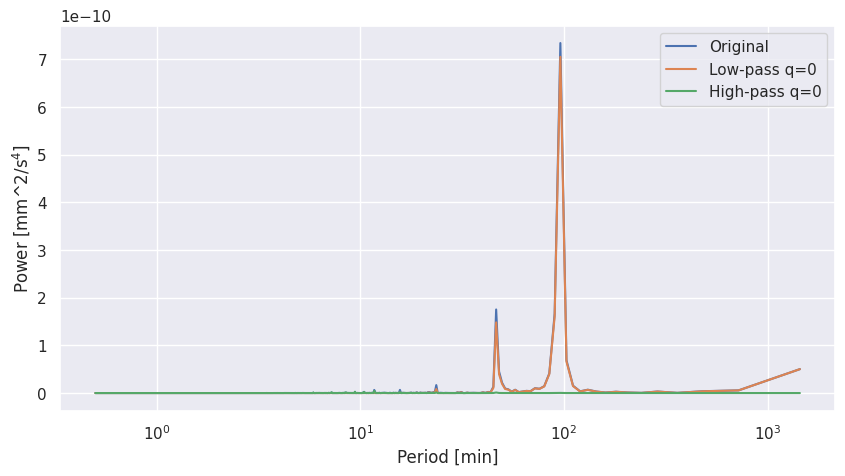

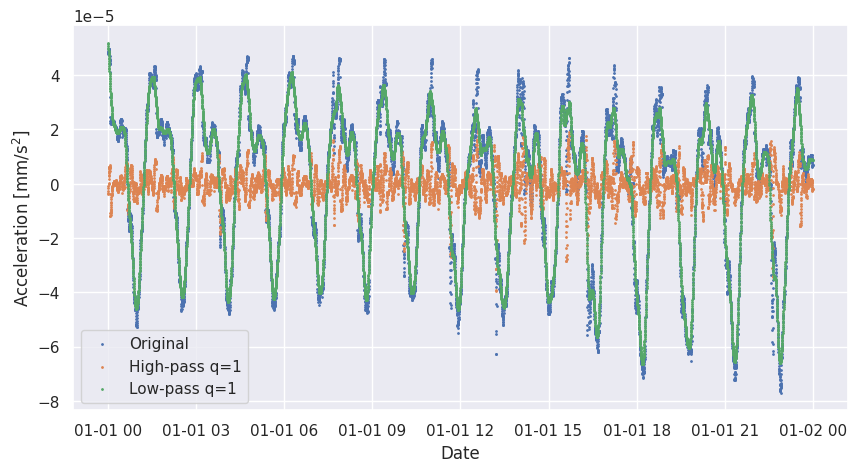

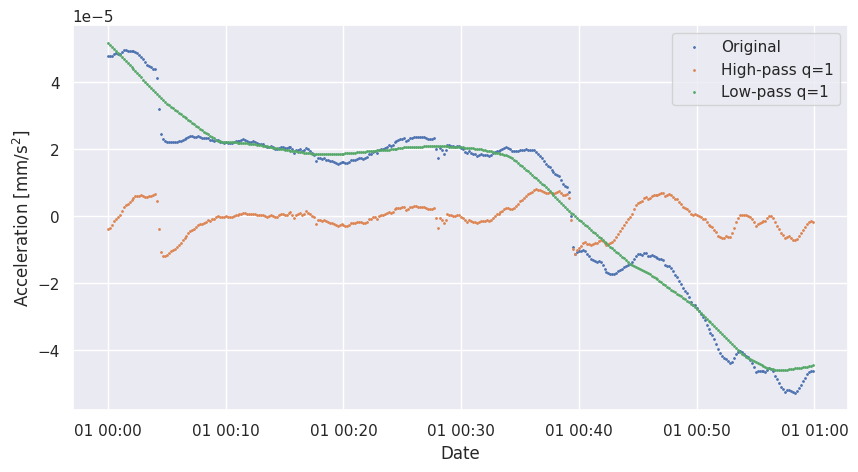

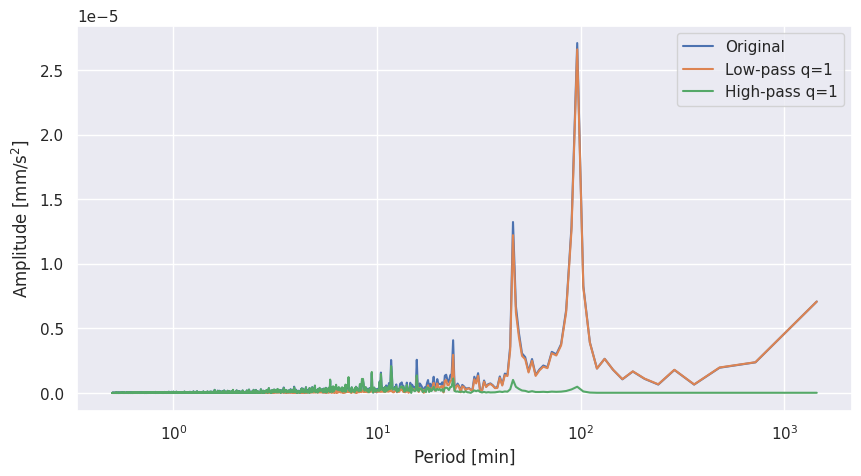

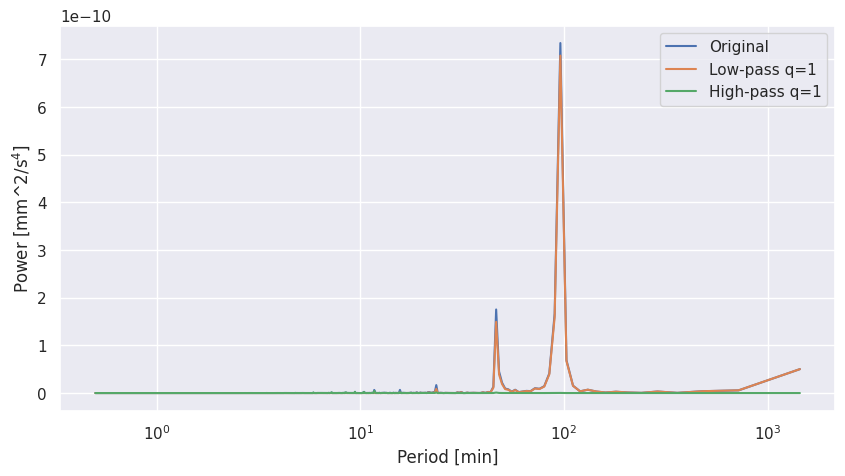

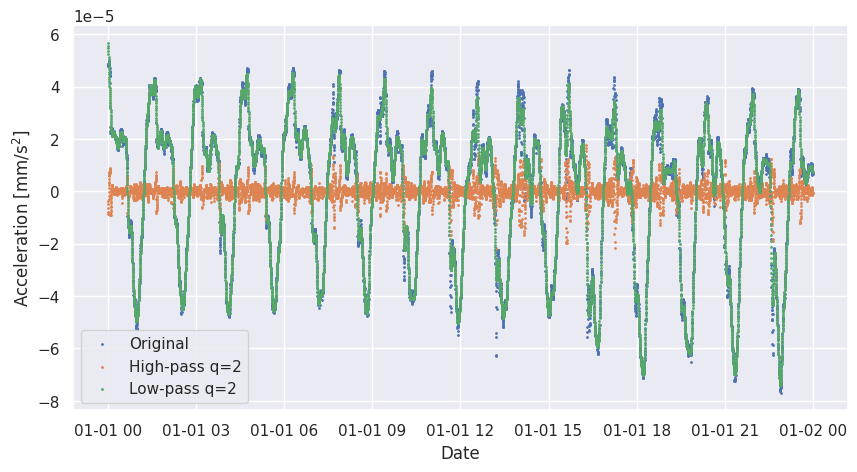

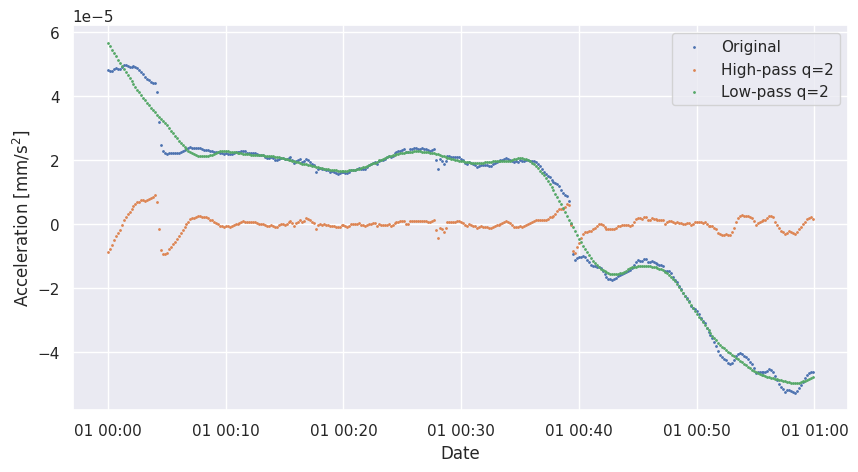

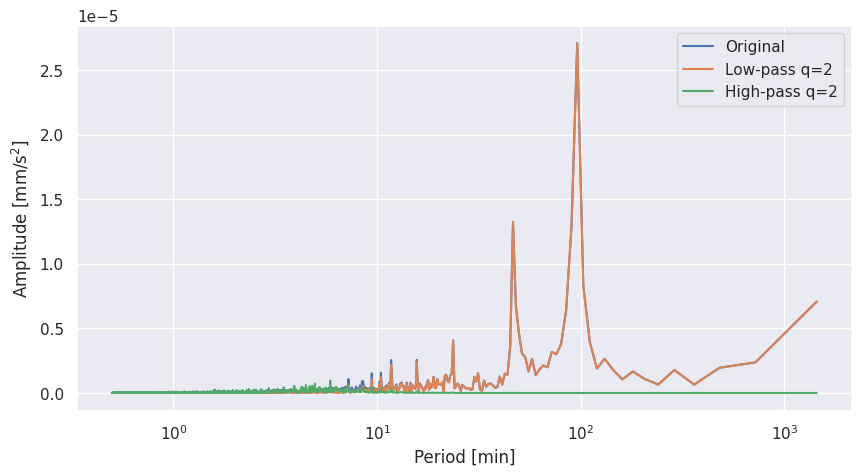

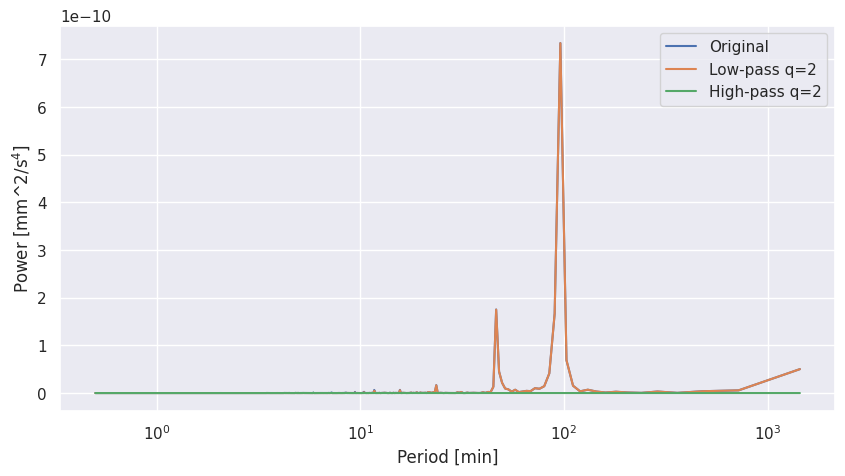

In [7]:
analize_data(data_sample['date'], data_sample['S_lin'], window = 61, edge = 'polynomial')

In [8]:
def fourier_analize(data, m, dt, use_functional_model = False):
    # get amplitudes via my own DFT implementation
    if use_functional_model:
        f = nmp_util.DFT_FunctionalModel(m)
        f.fit(np.arange(len(data)), data)
        coeffs = f.parameters
        amplitudes = f.amplitudes()
    else:
        coeffs = nmp_util.discrete_fourier_transform(data, m)
        amplitudes = nmp_util.coeffs_to_amplitude(coeffs)

    # and via numpy
    freqs, amplitudes_np = nmp_util.amplitude_spectrum_via_numpy(data, m, d=dt/60)
    
    m_max = np.argmax(amplitudes)
    print(f'n_max = {m_max}')
    print(f'perid = {1/freqs[m_max]} [min]')
    print(f'amplitude = {amplitudes[m_max]} [mm$^2$/s]')
    print(f'coefficients a = {coeffs[m_max]} [mm/s$^2$]')
    print(f'coefficients b = {coeffs[m_max + m]} [mm/s$^2$]') 
    plt.figure(figsize=(10, 5))
    plt.title(f'Fourier Analysis m = {m}')
    plt.scatter(freqs, amplitudes, label='Amplitudes',s=10, marker='x')
    plt.scatter(freqs, amplitudes_np, label='Amplitudes numpy',s=5)
    plt.xlabel('frequency [1/min]')
    plt.ylabel('amplitude [mm$^2$/s]')
    plt.legend()
    plt.show()

n_max = 15
perid = 96.0 [min]
amplitude = 2.7092425415787457e-05 [mm$^2$/s]
coefficients a = 2.218015369696078e-05 [mm/s$^2$]
coefficients b = -1.5557644323264475e-05 [mm/s$^2$]


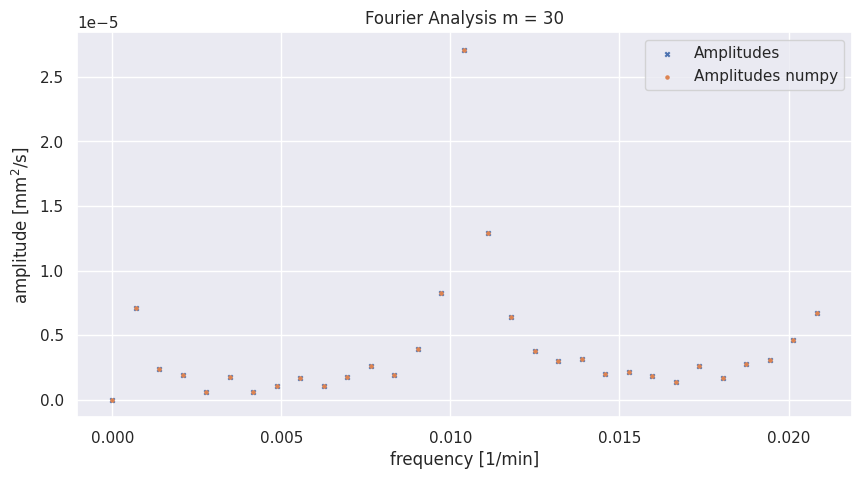

n_max = 15
perid = 96.0 [min]
amplitude = 2.7092425415787457e-05 [mm$^2$/s]
coefficients a = 2.218015369696078e-05 [mm/s$^2$]
coefficients b = -1.5557644323264475e-05 [mm/s$^2$]


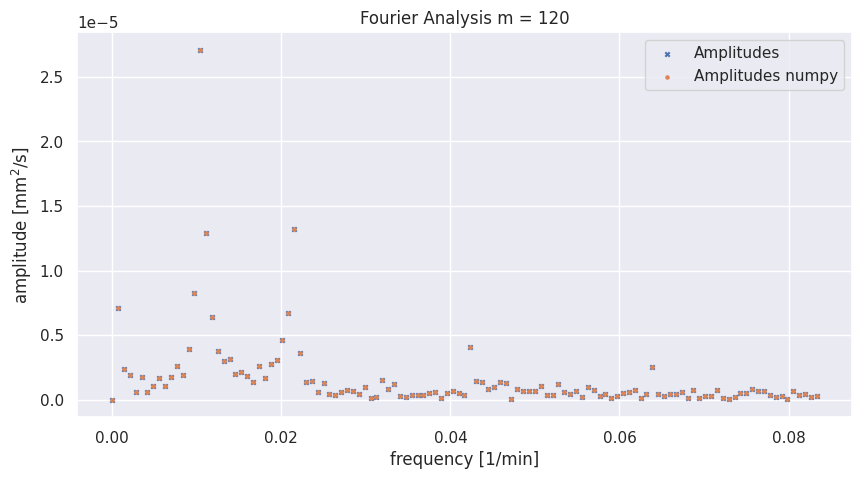

n_max = 15
perid = 96.0 [min]
amplitude = 2.7092425415787464e-05 [mm$^2$/s]
coefficients a = 2.2180153696960782e-05 [mm/s$^2$]
coefficients b = -1.5557644323264485e-05 [mm/s$^2$]


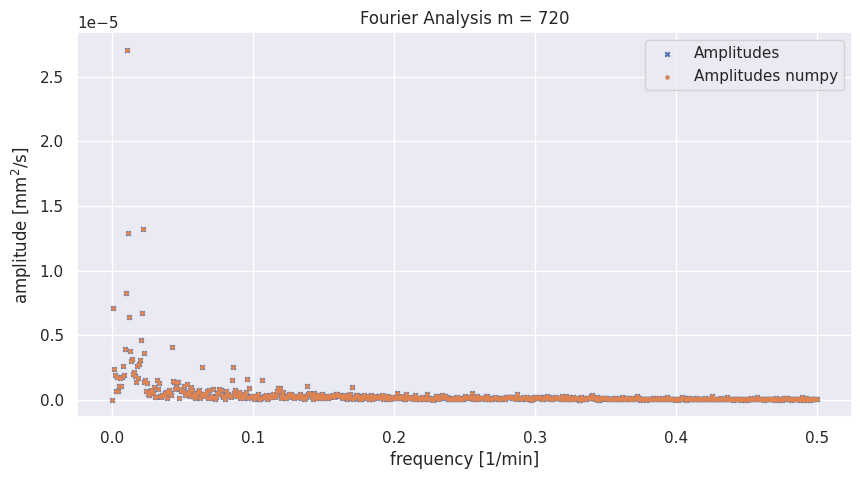

n_max = 15
perid = 96.0 [min]
amplitude = 2.7092425415787478e-05 [mm$^2$/s]
coefficients a = 2.218015369696079e-05 [mm/s$^2$]
coefficients b = -1.5557644323264492e-05 [mm/s$^2$]


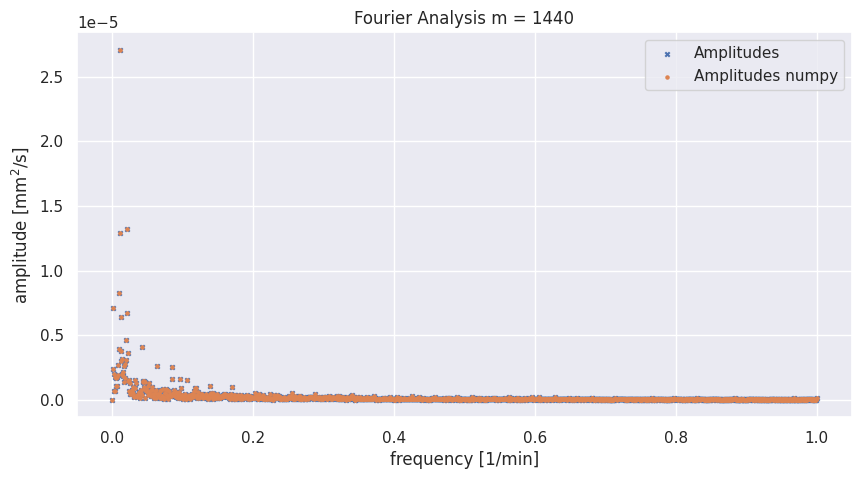

In [9]:
# analize the data with different m values
fourier_analize(data_sample['S_lin'], 30, dt = 10)
fourier_analize(data_sample['S_lin'], 120, dt = 10)
fourier_analize(data_sample['S_lin'], 720, dt = 10)
fourier_analize(data_sample['S_lin'], 1440, dt = 10)

# performance test

Unsurprisingly numpy is way faster. The funcitonal model and direct approach do show a difference, but it's not drastic.

In [10]:
def time_functional():
    f = nmp_util.DFT_FunctionalModel(720)
    f.fit(np.arange(len(data_sample['S_lin'])), data_sample['S_lin'])
def time_numpy():
    nmp_util.amplitude_spectrum_via_numpy(data_sample['S_lin'], 720, d=10/60)
def time_dft():
    nmp_util.discrete_fourier_transform(data_sample['S_lin'], 720)
%timeit time_functional()
%timeit time_dft()
%timeit time_numpy()

1.74 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.32 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
228 μs ± 31.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
